# Frequentist Upper limits  

Let's calculate the upper limit for our simple example counting experiment using a MC method. The first thing is to decide how we are going to generate pseudo-experiments (toys) to determine $f(t_{\mu}|H(\mu))$. We have again encountered the problem that $H(\mu)$ is defined only for a fixed choice of the nuisance parameters $\eta$. 

Once again, we'll turn to our choice of the *best* values, meaning we will pick those which minimises $q(\mu,\eta)$ for a given value of $\mu$ given our observed data.

For each toy, we want to generate a random value of the observation $n'$, given $\mu,\hat{\eta}_{\mu}$ and a value of $\eta'$ which represents the random outcome for $\eta$ our luminosity measurement - remember, in the frequentist view, the value that we obtained can also be interpreted as a random variable with a known distribution $\eta{^{\prime}}\sim\phi(\hat{\eta}_{\mu},1)$, our observed data then becomes $(n^{\prime},\eta^{\prime})$. We need to modify the likelihood function for each toy slightly to read, 

$$
    L(\alpha,\eta) = L(n^{\prime},\eta^{\prime}) = \lambda(\mu,\eta)^{n\prime}e^{-\lambda}\cdot e^{-\frac{1}{2}(\eta-\eta^{\prime})^{2}},
$$

For each toy, we can then calculate $t_{\mu}$ using this data in the likelihood function and histogram the results. Note that for each toy, we will find different values of $\hat{\mu}$ and $\hat{\eta}_{\mu}$! 

We've seen many of the functions we need before but let's copy the ones we need here and modify them to account for the fact that $\eta^{\prime}\neq 0$ necessarily...

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from counting_model_functions import *

Since we need to know the global minimum, we'll write a function do find that for us. 

Rather than writing the derivatives in  terms of $\mu$ and using a 2D method, we will rely on the `minimize` function from the `scipy.optimize` package to find the minimum point in 2D for us. 

In [2]:
from scipy.optimize import minimize
    
def global_min(n_p,eta_p):
    init = [1.,-1.]
    bounds=[[0,20],[-5,5]]
    res = minimize(q_formin,init,args=[n_p,eta_p],bounds=bounds)
    return res.fun,res.x[0]

Now we are ready to define the test statistic. The typical  one we use in HEP is 

$$
    t_{\mu} = \begin{cases}
                q(\mu,\hat{\eta}_{\mu})-q(\hat{0},\hat{\eta}_{0})    & \hat{\mu} < 0 \\
                q(\mu,\hat{\eta}_{\mu})-q(\hat{\mu},\hat{\eta})    & \hat{\mu} \in (0,\mu] \\
                0               & \hat{\mu}>\mu,
                \end{cases}
$$

so let's define a function for this. 

In [3]:
# calculate test statistic
def tmu(n_p,eta_p,mu):
  q_value        = q(mu,profiled_eta(n_p,eta_p,mu),n_p,eta_p)
  q_min,mu_min   = global_min(n_p,eta_p)
  #print("toy",mu,n_p,eta_p,q_value, q_min,mu_min, q_value-q_min)
  if mu_min < 0     : return q_value-q(n_p,eta_p,0,profiled_eta(n_p,eta_p,0))
  elif mu_min <= mu : return q_value-q_min
  else              : return 0

vectorized_tmu = numpy.vectorize(tmu)

We'll need to determine the test-statistic distribution for each value of the parameter of interest ($\mu$) so again, let's define a function for that.   

The function below returns the distribution of the test statistic at a specific value of $\mu$ and, when provided with the observed value, will calculate the $p$-value

$$
    p_{\mu} = \int_{t^{\mathrm{obs}}_{\mu}}^{+\infty} f(t_{\mu}|H(\mu))dt_{\mu}.
$$

In [4]:
def histo_tmu(mu,t_obs):
  # find the best (profiled) nuisance parameter values for the data (n,0)
  eta_profiled = profiled_eta(n,0,mu)
  ntoys = 1000
  toy_n   = numpy.random.poisson(lamb(mu,eta_profiled),size=ntoys)
  toy_eta = numpy.random.normal(eta_profiled,1,size=ntoys)
  #tmu_dist = [tmu(n_p,eta_p,mu) for n_p,eta_p in zip(toy_n,toy_eta)]
  tmu_dist = vectorized_tmu(toy_n,toy_eta,mu)
  return tmu_dist, float(len(list(filter(lambda tm: tm > t_obs,tmu_dist))))/len(tmu_dist)

As an example, we'll show the distribution for $\mu=8$ and $\mu=15$ and calculate $p_{8}$ and $p_{15}$. 

p_8 =  0.1519
p_15 =  0.0159


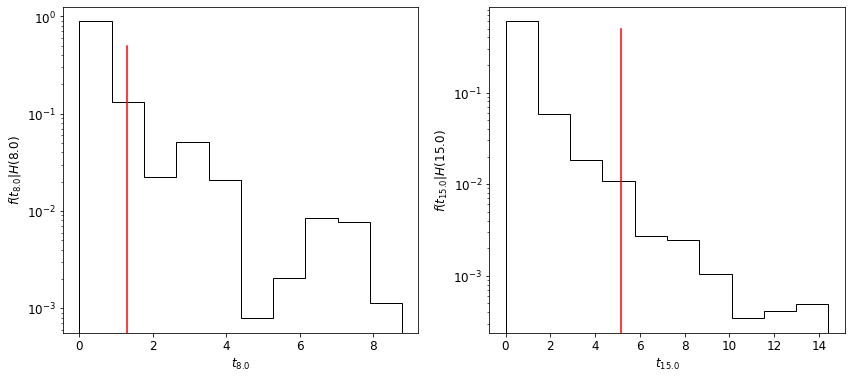

<Figure size 432x288 with 0 Axes>

In [5]:
t_obs8  = tmu(n,0,8)
t_obs15 = tmu(n,0,15)

tmu_toys8,pval8   = histo_tmu(8,t_obs8)
tmu_toys15,pval15 = histo_tmu(15,t_obs15)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.hist(tmu_toys8,density=True,color='black',histtype='step')
ax1.plot([t_obs8,t_obs8],[0,0.5],color='red')
ax1.set_yscale("log")
ax1.set_xlabel("$t_{%.1f}$"%8)
ax1.set_ylabel("$f(t_{%.1f}|H(%.1f)$"%(8,8))

ax2.hist(tmu_toys15,density=True,color='black',histtype='step')
ax2.plot([t_obs15,t_obs15],[0,0.5],color='red')
ax2.set_yscale("log")
ax2.set_xlabel("$t_{%.1f}$"%15)
ax2.set_ylabel("$f(t_{%.1f}|H(%.1f)$"%(15,15))

print("p_8 = ",pval8)
print("p_15 = ",pval15)
plt.show()
plt.savefig("p10.pdf")

The red lines indicates the observed value of the test-statistic. In the case that $\mu=8$ the $p$-value is larger than 0.05, while for $\mu=15$, the $p$-value is smaller than 0.05. We know therefore that the uppre limit lies somewhere between these two values.  

Now let's try a  range of values to search for the largest value of $\mu$ for which $p_{\mu}$>0.05. This value $\mu_{up}$ is our 95% CL upper limit on $\mu$. 

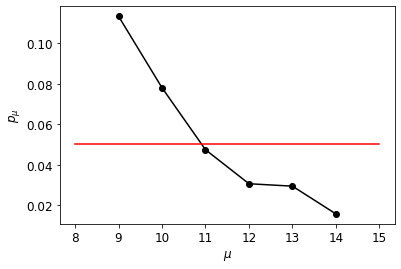

<Figure size 432x288 with 0 Axes>

In [6]:
p_mu_list = []
mu_test_list = numpy.arange(9,15,1)

for mu_test in mu_test_list :
  t_obs = tmu(n,0,mu_test)
  tmu_toys,pval = histo_tmu(mu_test,t_obs)
  p_mu_list.append(pval)

# from the graph, we can read of upper limits (eg for 95\% CL)
plt.plot(mu_test_list,p_mu_list,color='black',marker="o")
plt.plot([8,15],[0.05,0.05],color='red')

plt.xlabel("$\mu$")
plt.ylabel("$p_{\mu}$")
plt.show()
plt.savefig("scan_pmu.pdf")

We can find the upper limit by reading off where the black line crosses the red horizontal line at 0.05. In our simple counting experiment the 95% CL upper limit is $\mu_{up}\sim 11$.